In [1]:
%load_ext autoreload
%autoreload 2
import os
from pathlib import Path

In [2]:
original_dir = os.getcwd()
project_root = Path.cwd().parent
os.chdir(project_root)

In [3]:
from datasets import load_dataset
import pprint
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from src.data_processing import get_tag_dict, get_category_tags, get_topk_categories_by_subject,get_processed_dataset,_process_dataset
from src.config import DataConfig

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [4]:
ds_raw = load_dataset("TimSchopf/arxiv_categories", "default")
ds_cats = load_dataset("TimSchopf/arxiv_categories",  "arxiv_category_descriptions",
                       split="arxiv_category_descriptions")

## Structure of data
Two different Dataset objects 
1. "default" which contains the follwoing relevant features for our problem:
    - title, abstract, categories
   
2. "arxiv_category_description" which contains features that describe each category in the dataset
    - tag, name

Therefore, We will need the 'tag' feature of the second dataset to identify all the categories
available in this dataset and then map that to information in the 'categories' feature of
the identify the category specific to that datapoint

**NOTE** - there maybe multiple "tags" within the "categories" field for a given paper, 
since a paper coudl actually belong to multiple category. But perhaps, its best to label
each paper based on the first "tag" encountered in "categories".

In [5]:
all_tags = get_tag_dict(ds_cats)
pprint.pprint([v for (k, v) in all_tags.items()]) # Let's take a look at all the tags

['cs.AI',
 'cs.AR',
 'cs.CC',
 'cs.CE',
 'cs.CG',
 'cs.CL',
 'cs.CR',
 'cs.CV',
 'cs.CY',
 'cs.DB',
 'cs.DC',
 'cs.DL',
 'cs.DM',
 'cs.DS',
 'cs.ET',
 'cs.FL',
 'cs.GL',
 'cs.GR',
 'cs.GT',
 'cs.HC',
 'cs.IR',
 'cs.IT',
 'cs.LG',
 'cs.LO',
 'cs.MA',
 'cs.MM',
 'cs.MS',
 'cs.NA',
 'cs.NE',
 'cs.NI',
 'cs.OH',
 'cs.OS',
 'cs.PF',
 'cs.PL',
 'cs.RO',
 'cs.SC',
 'cs.SD',
 'cs.SE',
 'cs.SI',
 'cs.SY',
 'econ.EM',
 'econ.GN',
 'econ.TH',
 'eess.AS',
 'eess.IV',
 'eess.SP',
 'eess.SY',
 'math.AC',
 'math.AG',
 'math.AP',
 'math.AT',
 'math.CA',
 'math.CO',
 'math.CT',
 'math.CV',
 'math.DG',
 'math.DS',
 'math.FA',
 'math.GM',
 'math.GN',
 'math.GR',
 'math.GT',
 'math.HO',
 'math.IT',
 'math.KT',
 'math.LO',
 'math.MG',
 'math.MP',
 'math.NA',
 'math.NT',
 'math.OA',
 'math.OC',
 'math.PR',
 'math.QA',
 'math.RA',
 'math.RT',
 'math.SG',
 'math.SP',
 'math.ST',
 'astro-ph',
 'astro-ph.CO',
 'astro-ph.EP',
 'astro-ph.GA',
 'astro-ph.HE',
 'astro-ph.IM',
 'astro-ph.SR',
 'cond-mat',
 'cond-mat

In [ ]:
ds_raw['train'][:20]['categories'] # Take a look at the categories field in the raw training set

## Pattern matching strategy

1. The category field in the datast may contain 1 or more categories. Therefore, we need
   to process each of these

2. The pattern to match i.e the thing that appears in the tags always appears after a -> 
   , and is either flanked by another -> or a white space?

3. Therefore, we will need a function that extracts the parts of the 'categories' string 
   that has the following pattern : ->x-> or ->x. This function will need to be applied
   to each category for a specific datapoint.  

4. **Always** the first -> appears after the word 'Archive'

In [ ]:
ds_raw = ds_raw.map(lambda x: get_category_tags(x, all_tags), load_from_cache_file=False)

In [ ]:
def get_sorted_counts(d: list[str]):

    count_dict = dict(Counter(d))
    count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
    return count_dict


subject_counts = get_sorted_counts(ds_raw["train"]['subject'])


In [ ]:
subject_names_short = list(map(lambda x: x[:3].upper(),list(subject_counts.keys())))
plt.bar(list(subject_names_short),subject_counts.values())
plt.title('Number of papers by subject (training split only)')
plt.xlabel('subjects')
plt.ylabel('paper counts')

### STRATEGY FOR FILTERING DATA 
The above distribution seems to suggest that 
1. The 3 'subjects' with the most papers in this dataset are - Physiccs (PHY), Mathematics (MAT)  and Computer Science (COM).

2. The remaining subjects have very few datapoints in comparison, so for convenience we will just
remove those other subjects

3. PHYsics still have thrice the number of papers in MATh or COMputer Science. So we will need to
take into consideration data-class imbalance

Now within each of these top-level subjects, let's look at the distribution of individual categories.
For starters let's looks at the top-10 categories within each subject

In [ ]:
num_categories_per_subject = 8
topk_category_counts_by_subject = get_topk_categories_by_subject(ds_raw["train"]["category"], ds_raw["train"]["subject"], k = num_categories_per_subject)

In [ ]:
subjects_to_retain = ["Physics", "Mathematics", "Computer Science"]
x = np.arange(len(subjects_to_retain))  # the label locations
width = 0.05  # the width of the bars

fig, ax = plt.subplots(layout='constrained',figsize = (12,12))
for i, subj in enumerate(subjects_to_retain):
    multiplier = 0
    total_subj_count = 0
    for tag, counts in topk_category_counts_by_subject[subj].items():
        offset = width * multiplier
        rects = ax.bar(i + offset, counts, width, label=tag)
        ax.bar_label(rects, padding=5)
        multiplier += 1
        total_subj_count += counts

    print(f"total papers in {subj} retained via top-8: {total_subj_count}")
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Paper counts')
ax.set_xlabel('Top-level subjects')
ax.set_title(f'Tag distribution by subject (training only) - Top {num_categories_per_subject} categories')
ax.set_xticks(x + width, subjects_to_retain)
ax.legend(loc='upper right', ncols=3)


plt.show()

A critical thing to notice in the above plot is that the second most frequent category in Physics is "astro-ph", 
which is clearly missing further information which subcategory of astrophysics these papers belong to. For example, 
the last cateogry within physics is astro-ph.CO which indicates that these papers belogn to the "cosmology" 
specialization. Therefore, we needsome way of recategorizing the papers that have this incomplete label information 
into specific categories. Some approaches to consider are - 

1. Merge astro-ph into the speccialized sub-category that occurs the most (for e.g astro-ph gets merged into astro-ph.CO)
2. Randomly assign astro-ph papers to specialized sub-categories within astro-physics, either with a uniform distribution
or in proportion to occurences of each sub-category.

I am inclined to believe strategy #2 is better

In [ ]:
data_config = DataConfig(num_categories_per_subject=8)
ds_processed = get_processed_dataset(data_config)

In [ ]:
def analyze_sequence_lengths(dataset, tokenizer):
    
    lengths = []
    for example in dataset['train']:
        tokens = tokenizer(example['input'], truncation=False)['input_ids']
        lengths.append(len(tokens))
    
    lengths = np.array(lengths)
    
    print(f"Mean length: {lengths.mean():.1f}")
    print(f"Median length: {np.median(lengths):.1f}")
    print(f"90th percentile: {np.percentile(lengths, 90):.1f}")
    print(f"95th percentile: {np.percentile(lengths, 95):.1f}")
    print(f"99th percentile: {np.percentile(lengths, 99):.1f}")
    print(f"Max length: {lengths.max()}")
    
    return lengths

In [ ]:
token_lengths = analyze_sequence_lengths(ds_processed, tokenizer)

In [ ]:
print(tokenizer(ds_processed["train"][0]["input"], padding="max_length", truncation=True, max_length=512)['input_ids'])

In [ ]:
tokenizer.decode(0)

In [15]:
data_config = DataConfig()
data_config.num_categories_per_subject = 15
processed_dataset, id2label = _process_dataset(data_config)

 Extracting category and subject-level information


Map: 326336 examples [00:22, 7361.82 examples/s]           
Map: 40792 examples [00:02, 6959.28 examples/s]          
Map: 40794 examples [00:02, 7112.50 examples/s]          


Found parent categories: ['astro-ph', 'cond-mat']
Generated Re-labeling Plan: {'astro-ph': {'children': ['astro-ph.CO', 'astro-ph.GA', 'astro-ph.HE', 'astro-ph.SR', 'astro-ph.EP', 'astro-ph.IM'], 'probs': [0.2863582443653618, 0.22502965599051009, 0.18256227758007118, 0.14329774614472124, 0.1136417556346382, 0.04911032028469751]}, 'cond-mat': {'children': ['cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'cond-mat.str-el', 'cond-mat.stat-mech', 'cond-mat.soft', 'cond-mat.supr-con', 'cond-mat.dis-nn', 'cond-mat.quant-gas', 'cond-mat.other'], 'probs': [0.2642530353686433, 0.23812247052613056, 0.15190040471581912, 0.09915537568185817, 0.08657399260953721, 0.06409466830899173, 0.039547774062994895, 0.03651240541967271, 0.019839873306352278]}}


Map: 100%|██████████| 20397/20397 [00:00<00:00, 23958.32 examples/s]


 Cleaning input text 


Map: 326336 examples [00:42, 3837.59 examples/s]           
Map: 100%|██████████| 20397/20397 [00:08<00:00, 2394.27 examples/s]


Retaining top 15 categories in subjects: Physics, Mathematics, Computer Science...


Filter: 100%|██████████| 20397/20397 [00:01<00:00, 15321.62 examples/s]


 Categories retained: math.MP, cs.DM, math.DG, math.GT, math.PR, cs.NI, cs.DS, math.FA, math.NT, quant-ph, cs.CV, astro-ph.EP, hep-ex, cond-mat.mtrl-sci, astro-ph.HE, cs.CL, cond-mat.stat-mech, gr-qc, cs.SY, math.CO, astro-ph.CO, math.CA, cond-mat.mes-hall, cs.IT, math.AP, math.CV, cs.LG, cond-mat.soft, cs.LO, hep-th, math.AG, math.ST, hep-ph, astro-ph.GA, cond-mat.str-el, cs.NA, math.DS, math.GR, math.OC, cs.CR, cs.RO, cs.DC, astro-ph.SR, cs.AI, cs.SE
Mapping filtered examples to labels


Map: 100%|██████████| 16217/16217 [00:03<00:00, 5364.47 examples/s]


In [16]:
num_categories_per_subject = 15
topk_category_counts_by_subject = get_topk_categories_by_subject(processed_dataset["train"]["category"], processed_dataset["train"]["subject"], k = num_categories_per_subject)

total papers in Physics retained via top-8: 73450
total papers in Mathematics retained via top-8: 27659
total papers in Computer Science retained via top-8: 28646


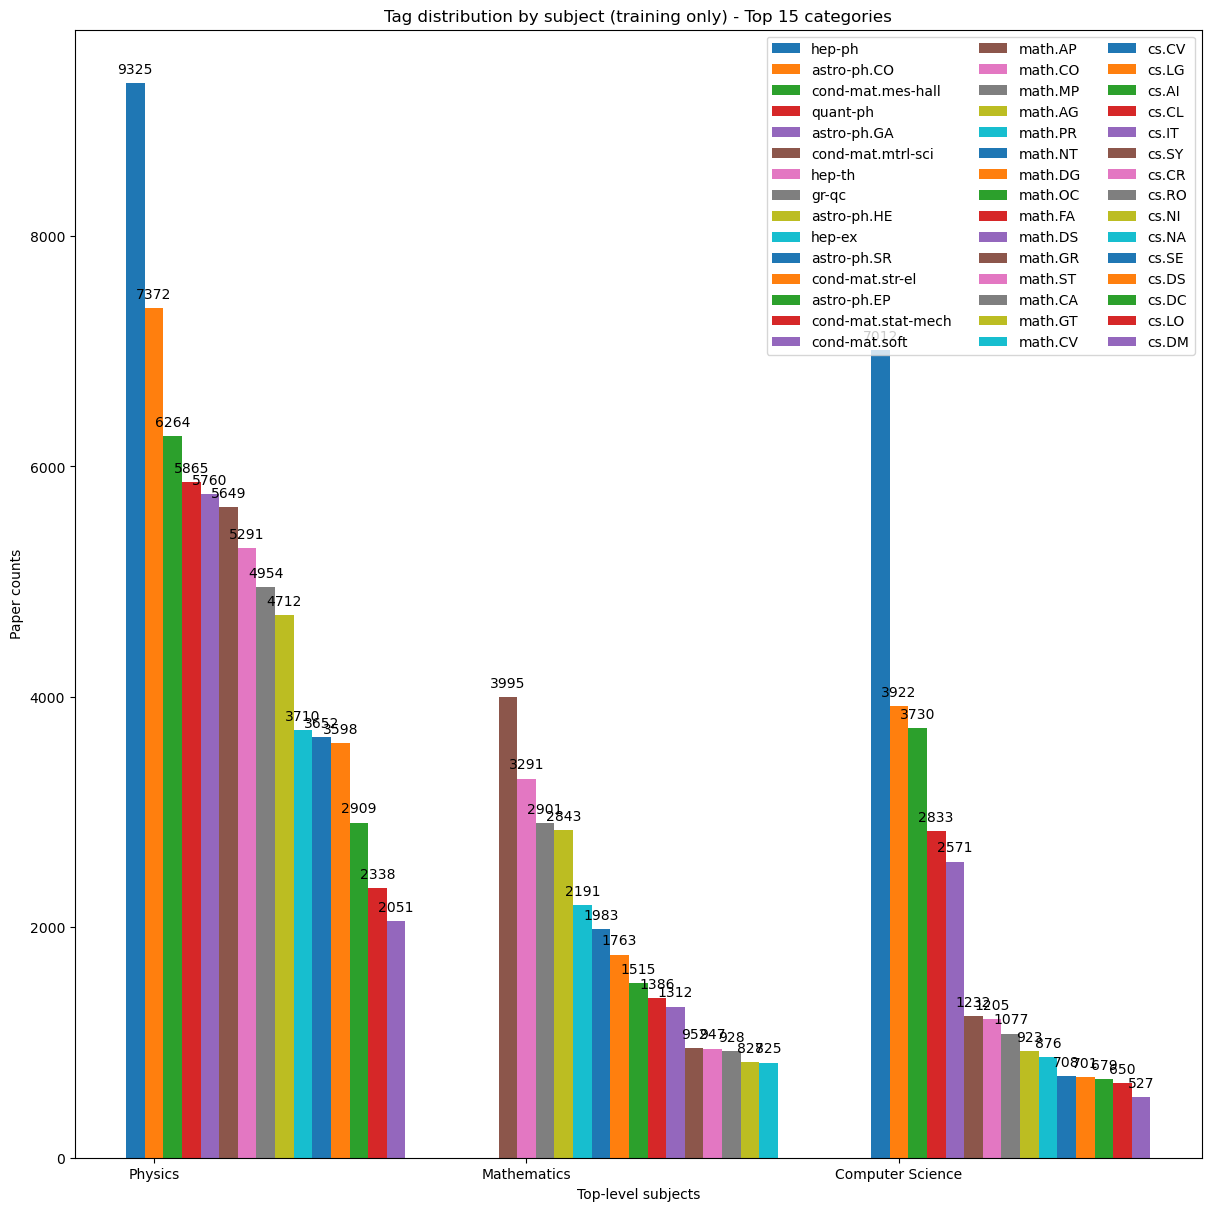

In [17]:
subjects_to_retain = ["Physics", "Mathematics", "Computer Science"]
x = np.arange(len(subjects_to_retain))  # the label locations
width = 0.05  # the width of the bars

fig, ax = plt.subplots(layout='constrained',figsize = (12,12))
for i, subj in enumerate(subjects_to_retain):
    multiplier = 0
    total_subj_count = 0
    for tag, counts in topk_category_counts_by_subject[subj].items():
        offset = width * multiplier
        rects = ax.bar(i + offset, counts, width, label=tag)
        ax.bar_label(rects, padding=5)
        multiplier += 1
        total_subj_count += counts

    print(f"total papers in {subj} retained via top-8: {total_subj_count}")
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Paper counts')
ax.set_xlabel('Top-level subjects')
ax.set_title(f'Tag distribution by subject (training only) - Top {num_categories_per_subject} categories')
ax.set_xticks(x + width, subjects_to_retain)
ax.legend(loc='upper right', ncols=3)


plt.show()

In [11]:
processed_bad = processed_dataset['train'].filter(lambda example: example['primary_category'] == 'astro-ph')

Filter: 100%|██████████| 94544/94544 [00:09<00:00, 10141.67 examples/s]


In [ ]:
processed_bad[0:100]['categories']

[['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph',
  'Physics Archive->gr-qc',
  'Physics Archive->hep->hep-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph', 'Physics Archive->hep->hep-ph'],
 ['Physics Archive->astro-ph',
  'Physics Archive->gr-qc',
  'Physics Archive->hep->hep-ph',
  'Physics Archive->hep->hep-th'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph',
  'Physics Archive->gr-qc',
  'Physics Archive->hep->hep-ph',
  'Physics Archive->hep->hep-th'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics Archive->astro-ph'],
 ['Physics

In [14]:
processed_bad[0:100]['category']

['astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.GA',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.GA',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.GA',
 'astro-ph.GA',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.GA',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.CO',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.GA',
 'astro-ph.GA',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-ph.GA',
 'astro-ph.CO',
 'astro-